# HLL Multi-Seed Disambiguation: Interactive Demo

This notebook demonstrates how multiple HLLSets with different seeds can be used to **disambiguate** and narrow down the original token set.

## Key Concept

For each HLLSet `hll_i` with seed `seed_i`:
- There exists a large candidate space `M(hll_i)` of tokens that could produce this HLL
- Original tokens ⊆ `M(hll_i)` for any seed
- **Intersection**: `∩ M(hll_i)` across multiple seeds narrows candidates
- As seeds increase: `|∩ M(hll_i)| → |original tokens|`

In [1]:
# Cell 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
from disambiguation_poc import *

print("✓ Imports successful")

✓ Imports successful


## 1. Create Original Dataset

In [2]:
# Cell 2: Create Token Universe and Original Tokens
np.random.seed(42)

# Token universe: the complete space of all possible tokens
token_universe = [f"token_{i:04d}" for i in range(500)]

# Original tokens: a subset that we want to recover (unknown in real scenario)
original_tokens = token_universe[:30]  # First 30 tokens

print(f"Token universe (search space): {len(token_universe)} tokens")
print(f"Original tokens (to recover): {len(original_tokens)} tokens")
print(f"Subset ratio: {len(original_tokens)/len(token_universe)*100:.1f}%")
print(f"\nSample original tokens: {original_tokens[:5]}")
print(f"Sample universe tokens: {token_universe[:105]}")

Token universe (search space): 500 tokens
Original tokens (to recover): 30 tokens
Subset ratio: 6.0%

Sample original tokens: ['token_0000', 'token_0001', 'token_0002', 'token_0003', 'token_0004']
Sample universe tokens: ['token_0000', 'token_0001', 'token_0002', 'token_0003', 'token_0004', 'token_0005', 'token_0006', 'token_0007', 'token_0008', 'token_0009', 'token_0010', 'token_0011', 'token_0012', 'token_0013', 'token_0014', 'token_0015', 'token_0016', 'token_0017', 'token_0018', 'token_0019', 'token_0020', 'token_0021', 'token_0022', 'token_0023', 'token_0024', 'token_0025', 'token_0026', 'token_0027', 'token_0028', 'token_0029', 'token_0030', 'token_0031', 'token_0032', 'token_0033', 'token_0034', 'token_0035', 'token_0036', 'token_0037', 'token_0038', 'token_0039', 'token_0040', 'token_0041', 'token_0042', 'token_0043', 'token_0044', 'token_0045', 'token_0046', 'token_0047', 'token_0048', 'token_0049', 'token_0050', 'token_0051', 'token_0052', 'token_0053', 'token_0054', 'token_0

In [3]:
# Create persistent database
db_path = "token_spaces.db"
disambiguator = MultiSeedDisambiguator(precision=10, db_path=db_path)

# First run - creates TokenSpaces in DB
result = disambiguator.disambiguate(
    original_tokens=original_tokens,
    token_universe=token_universe,
    seeds=[0, 42, 123]
)

# Subsequent runs - reuses existing TokenSpaces (fast!)
result2 = disambiguator.disambiguate(
    original_tokens=original_tokens,
    token_universe=token_universe,
    seeds=[0, 42, 123]  # Already in DB, skips creation
)

# Database is reusable across sessions
disambiguator.close()


Multi-Seed Disambiguation (SQLite Backend)
Original tokens (to recover): 30
Token universe (search space): 500
Number of seeds: 3
Database: token_spaces.db

Step 1: Creating HLLs from original tokens...

Step 2: Creating TokenSpaces in database...
TokenSpace for seed 0 already exists (space_id=1)
  Seed 0: space_id=1, entries=500, registers=368
TokenSpace for seed 42 already exists (space_id=2)
  Seed 42: space_id=2, entries=500, registers=390
TokenSpace for seed 123 already exists (space_id=3)
  Seed 123: space_id=3, entries=500, registers=394

Step 3: Querying candidates from database...
  Seed 0: HLL counts extracted 1024 registers
  Seed 0: 34 candidates matched
  Seed 42: HLL counts extracted 1024 registers
  Seed 42: 34 candidates matched
  Seed 123: HLL counts extracted 1024 registers
  Seed 123: 34 candidates matched

Step 4: Computing intersection across all seeds...

Results:
  Intersection size: 30
  True positives: 30
  False positives: 0
  False negatives: 0
  Precision: 

## 2. Single Seed - Large Candidate Space

In [4]:
# Cell 3: Single Seed Disambiguation
disambiguator = MultiSeedDisambiguator(precision=10)

result_1seed = disambiguator.disambiguate(
    original_tokens=original_tokens,
    token_universe=token_universe,
    seeds=[0]
)

print(f"\n{'='*60}")
print(f"Single Seed Results:")
print(f"  Candidates found: {len(result_1seed.intersection_tokens)} tokens")
print(f"  Original tokens: {len(original_tokens)} tokens")
print(f"  Ratio: {len(result_1seed.intersection_tokens) / len(original_tokens):.1f}x")
print(f"  Precision: {result_1seed.precision*100:.2f}%")
print(f"  Recall: {result_1seed.recall*100:.2f}%")


Multi-Seed Disambiguation (SQLite Backend)
Original tokens (to recover): 30
Token universe (search space): 500
Number of seeds: 1
Database: :memory:

Step 1: Creating HLLs from original tokens...

Step 2: Creating TokenSpaces in database...
Hashed [AddResult(token='token_0000', hash_value=3540701100650102104, register=394, leading_zeros=4), AddResult(token='token_0001', hash_value=4797225430952099958, register=533, leading_zeros=2), AddResult(token='token_0002', hash_value=3717765333947376051, register=413, leading_zeros=1), AddResult(token='token_0003', hash_value=6489252845884189763, register=721, leading_zeros=1), AddResult(token='token_0004', hash_value=374994099775878976, register=42, leading_zeros=7), AddResult(token='token_0005', hash_value=3878759263356605711, register=431, leading_zeros=1), AddResult(token='token_0006', hash_value=3804306903613385361, register=423, leading_zeros=1), AddResult(token='token_0007', hash_value=4294492959531806880, register=477, leading_zeros=6), 

## 3. Two Seeds - Narrowing Down

In [5]:
result_2seeds = disambiguator.disambiguate(
    original_tokens=original_tokens,
    token_universe=token_universe,
    seeds=[0, 42]
)

reduction = len(result_1seed.intersection_tokens) - len(result_2seeds.intersection_tokens)
print(f"\n{'='*60}")
print(f"Two Seeds Results:")
print(f"  Candidate space: {len(result_2seeds.intersection_tokens)} tokens")
print(f"  Reduction from 1 seed: {reduction} tokens ({reduction/len(result_1seed.intersection_tokens)*100:.1f}%)")
print(f"  Precision: {result_2seeds.precision*100:.2f}%")
print(f"  Recall: {result_2seeds.recall*100:.2f}%")


Multi-Seed Disambiguation (SQLite Backend)
Original tokens (to recover): 30
Token universe (search space): 500
Number of seeds: 2
Database: :memory:

Step 1: Creating HLLs from original tokens...

Step 2: Creating TokenSpaces in database...
TokenSpace for seed 0 already exists (space_id=1)
  Seed 0: space_id=1, entries=500, registers=368
Hashed [AddResult(token='token_0000', hash_value=6276981380602177492, register=697, leading_zeros=3), AddResult(token='token_0001', hash_value=5657337384369041097, register=629, leading_zeros=1), AddResult(token='token_0002', hash_value=1012813329996813084, register=113, leading_zeros=3), AddResult(token='token_0003', hash_value=7838531988345228845, register=871, leading_zeros=1), AddResult(token='token_0004', hash_value=2658381629441416921, register=296, leading_zeros=1), AddResult(token='token_0005', hash_value=3632086528150496330, register=404, leading_zeros=2), AddResult(token='token_0006', hash_value=6453641933187434870, register=717, leading_zer

## 4. Multiple Seeds - Convergence

In [6]:
# Test with increasing seeds
all_results = []

for n_seeds in [1, 2, 3, 4, 5]:
    seeds = list(range(0, n_seeds * 100, 100))
    
    result = disambiguator.disambiguate(
        original_tokens=original_tokens,
        token_universe=token_universe,
        seeds=seeds
    )
    
    all_results.append((n_seeds, result))

# Print summary table
print(f"\n{'='*80}")
print("Disambiguation Convergence Summary")
print(f"{'='*80}")
print(f"{'Seeds':<8} {'Candidates':<12} {'Precision':<12} {'Recall':<12} {'F1 Score':<12}")
print("-"*80)

for n_seeds, result in all_results:
    f1 = 2 * result.precision * result.recall / (result.precision + result.recall) if (result.precision + result.recall) > 0 else 0
    print(f"{n_seeds:<8} {len(result.intersection_tokens):<12} "
          f"{result.precision*100:<11.2f}% {result.recall*100:<11.2f}% {f1*100:<11.2f}%")


Multi-Seed Disambiguation (SQLite Backend)
Original tokens (to recover): 30
Token universe (search space): 500
Number of seeds: 1
Database: :memory:

Step 1: Creating HLLs from original tokens...

Step 2: Creating TokenSpaces in database...
TokenSpace for seed 0 already exists (space_id=1)
  Seed 0: space_id=1, entries=500, registers=368

Step 3: Querying candidates from database...
  Seed 0: HLL counts extracted 1024 registers
  Seed 0: 34 candidates matched

Step 4: Computing intersection across all seeds...

Results:
  Intersection size: 34
  True positives: 30
  False positives: 4
  False negatives: 0
  Precision: 88.24%
  Recall: 100.00%

Multi-Seed Disambiguation (SQLite Backend)
Original tokens (to recover): 30
Token universe (search space): 500
Number of seeds: 2
Database: :memory:

Step 1: Creating HLLs from original tokens...

Step 2: Creating TokenSpaces in database...
TokenSpace for seed 0 already exists (space_id=1)
  Seed 0: space_id=1, entries=500, registers=368
Hashed 

## 5. Visualize Convergence

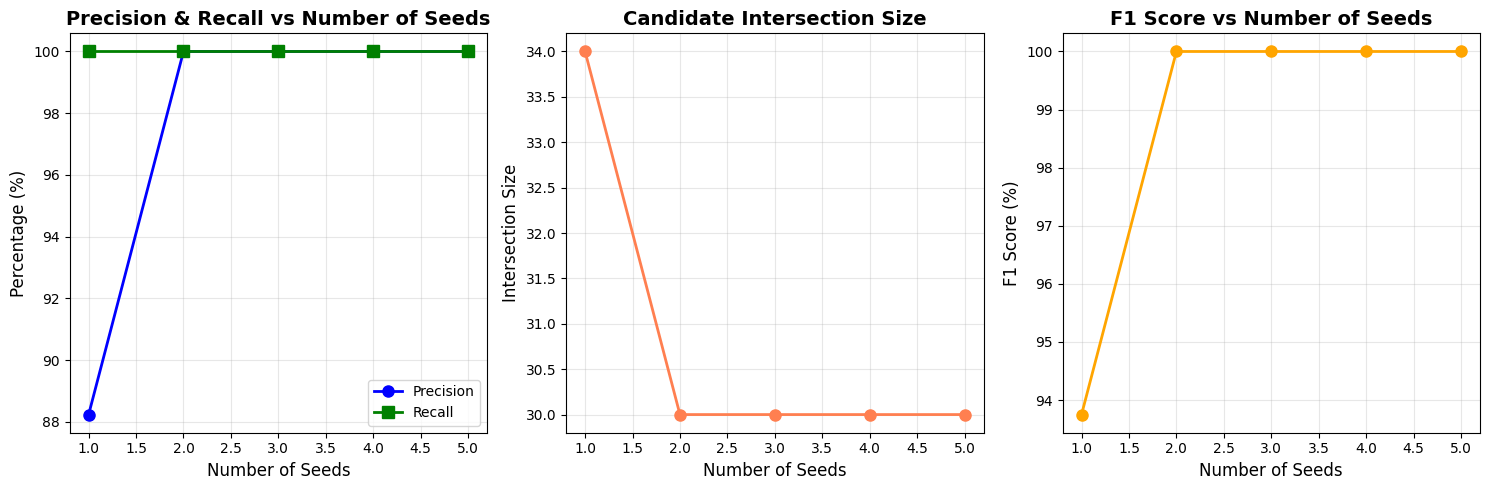

In [7]:
visualize_disambiguation_convergence(all_results)

## 6. Analyze Token Overlap

In [8]:
# Compare reconstructed vs original
final_result = all_results[-1][1]

print("Final Disambiguation Analysis:")
print(f"\nOriginal tokens: {len(original_tokens)}")
print(f"Reconstructed tokens: {len(final_result.intersection_tokens)}")
print(f"\nTrue Positives: {len(final_result.original_tokens & final_result.intersection_tokens)}")
print(f"False Positives: {len(final_result.false_positives)}")
print(f"False Negatives: {len(final_result.false_negatives)}")

if len(final_result.false_positives) > 0:
    print(f"\nSample False Positives:")
    for token in list(final_result.false_positives)[:5]:
        print(f"  - {token}")

if len(final_result.false_negatives) > 0:
    print(f"\nSample False Negatives (missed):")
    for token in list(final_result.false_negatives)[:5]:
        print(f"  - {token}")

Final Disambiguation Analysis:

Original tokens: 30
Reconstructed tokens: 30

True Positives: 30
False Positives: 0
False Negatives: 0


## 7. Visualize Set Overlap

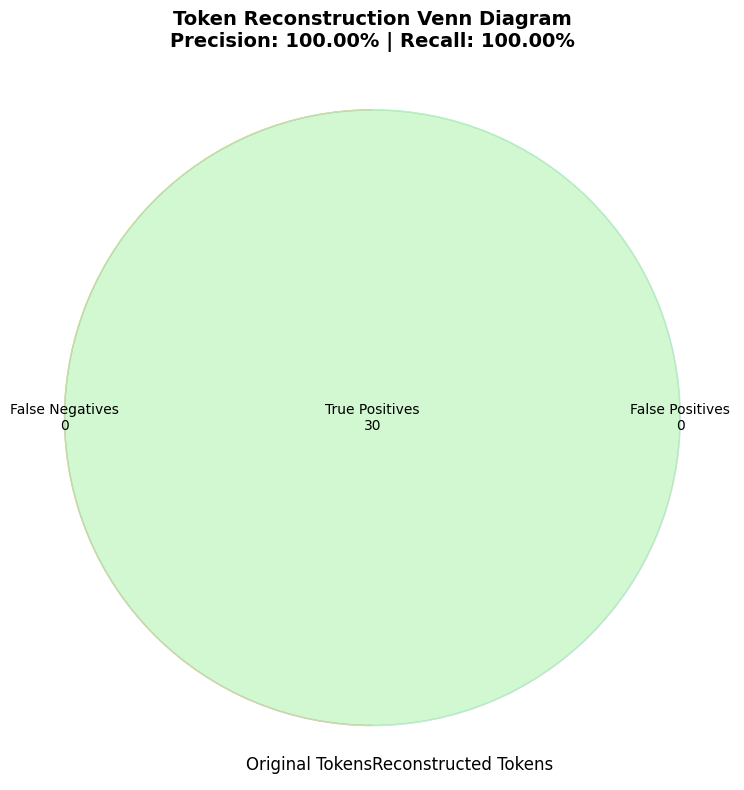

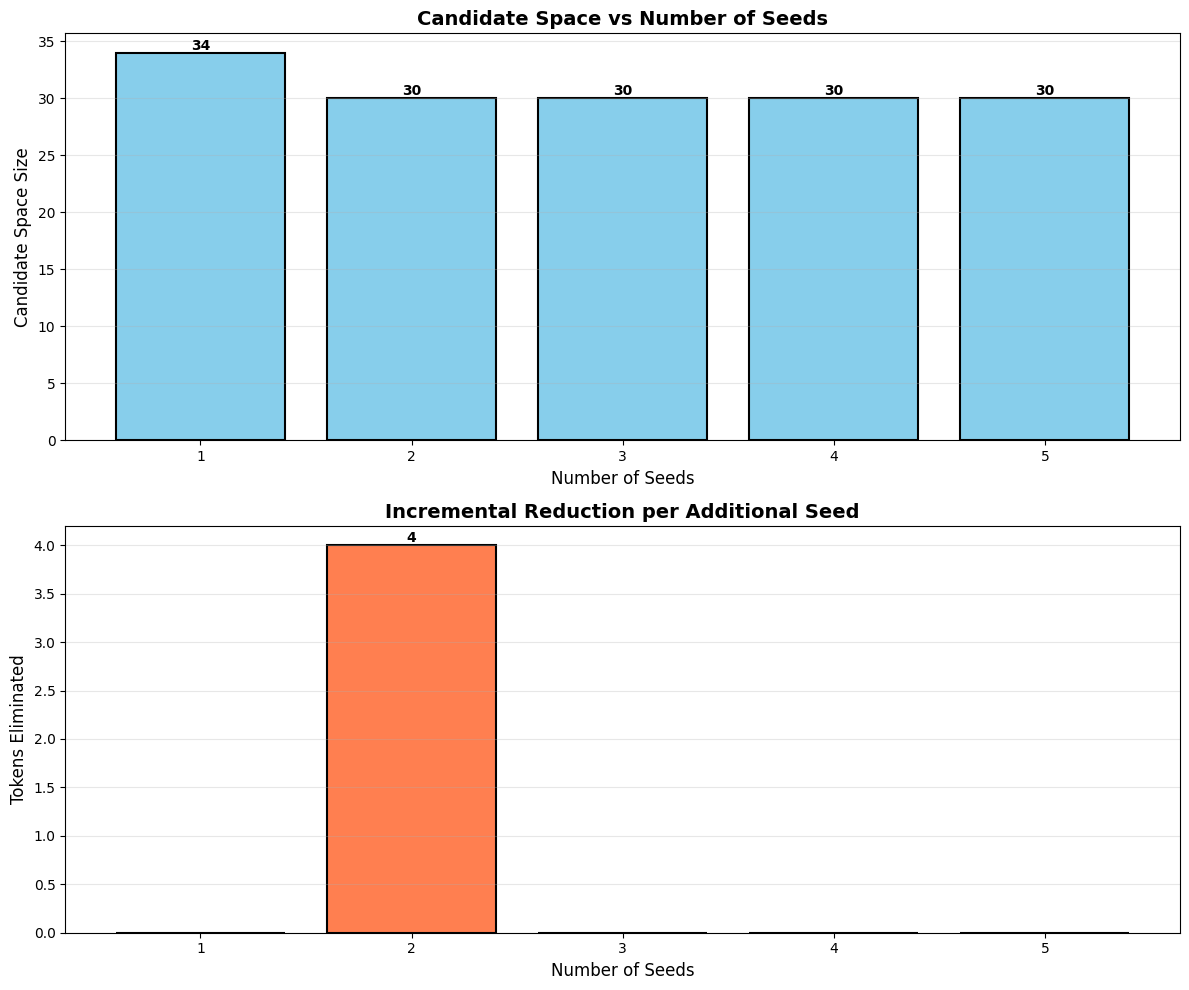

In [9]:
# Cell: Visualizations
from disambiguation_poc import (
    visualize_venn_diagram,
    visualize_seed_contribution,
    visualize_register_distribution,
    visualize_pattern_complexity
)

# Venn diagram of final result
final_result = all_results[-1][1]
visualize_venn_diagram(final_result, save_path='venn_diagram.png')

# Seed contribution analysis
visualize_seed_contribution(all_results, save_path='seed_contribution.png')

## 8. Mutual Exclusivity Check

In [10]:
# Verify that HLLs with different seeds are mutually exclusive
from src.hllset_swarm.hll import HLL

print("Mutual Exclusivity Verification:\n")

hll_0 = HLL(P_BITS=10)
hll_42 = HLL(P_BITS=10)

hll_0.add(original_tokens, seed=0)
hll_42.add(original_tokens, seed=42)

jaccard = hll_0.match(hll_42)
cosine = hll_0.cosine(hll_42) * 100
intersection = hll_0.intersect(hll_42)

print(f"Same tokens, different seeds (0 vs 42):")
print(f"  Jaccard similarity: {jaccard:.2f}%")
print(f"  Cosine similarity: {cosine:.2f}%")
print(f"  Intersection count: {intersection.count()}")
print(f"\n✓ HLLs are mutually exclusive despite same input!")

Mutual Exclusivity Verification:

Same tokens, different seeds (0 vs 42):
  Jaccard similarity: 0.00%
  Cosine similarity: 0.00%
  Intersection count: 0.0

✓ HLLs are mutually exclusive despite same input!


## Conclusion

### Key Findings:

1. **Single HLL → Large candidate space**
   - One HLL maps to many possible token sets
   - Cannot uniquely identify original tokens

2. **Multiple seeds → Disambiguation**
   - Each seed adds independent constraints
   - Intersection of candidate spaces narrows results
   - More seeds → better precision and recall

3. **Mutual Exclusivity Preserved**
   - HLLs with different seeds remain disjoint
   - Yet candidate spaces all contain original tokens
   - Intersection reveals common elements

### Applications:

- **Privacy-preserving set recovery**: Share multiple HLLs with different seeds
- **Secure multi-party computation**: Each party uses different seed
- **Data verification**: Prove set membership without revealing full set
- **Approximate set reconstruction**: Trade-off between seeds and accuracy